In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display_html, display, Math, HTML

# Markov Chain Monte Carlo

```{margin}
This lecture continues to draw on [these lecture notes](https://personal.math.ubc.ca/~holmescerfon/teaching.html#asanotes), in particular Chapter 3.
```

Now, we will start working our way back to Bayesian statistics.

Recall the strategy we have been using to construct posterior distributions -- the __grid__ approach

<center>
    
<img src="images/Grid-Bayesian-Update.jpg" width="650px">
    
</center>

This approach works well if we have only a few parameters: 1 or 2 or maybe 3.  But if we have more than three parameters, the size of the grid explodes.

Loosely speaking, the size of the grid is exponential in the number of parameters in our posterior.  So the grid approach can become infeasible for problems with large numbers of parameters.

The solution we will explore today will be to __not__ construct the whole posterior distribution.   Instead, we will find a way to __sample__ the posterior without actually constructing it!

The approach we will use is based on Markov chains.

## Detailed Balance

To set the stage we need to define a special case in which we always know that a Markov chain is in steady-state.

Consider an $n$-state Markov chain $P$, and a steady-state distribution of $P$ which we'll denote $\pi$.  So we know that $P\pi = \pi.$

In addition to being in steady-state, we say that the chain also satisfies __detailed balance__ with respect to $\pi$ if

$$ \pi_i P_{ji} = \pi_j P_{ij}\;\;\; \forall i, j. $$


There are $n^2$ of these equations, and they are called the _detailed balance equations._  

Note though that whenever $P_{ij} = 0$ we can ignore the associated equations, so there may not be $n^2$ equations that actually matter.  

What do the detailed balance equations represent?  

Suppose we start the chain in the stationary distribution, so that $X_0 \sim \pi.$  Then the quantity $\pi_i P_{ji}$ represents the "amount" of probability that flows down edge $i \rightarrow j$ in one time step.  

If the detailed balance equations hold, then the amount of probability flowing from $i$ to $j$ equals the amount that flows from $j$ to $i$.   Therefore there is no _net_ flux of probability along the edge $i \leftrightarrow j$.

```{margin}
This example is from [Chapter 3 of these notes.](https://personal.math.ubc.ca/~holmescerfon/teaching.html#asanotes)
```

A good analogy comes from thinking about traffic flow in New York city and surroundings: let each borough or suburb be represented by a node of the Markov chain, and join two nodes if there is a bridge or tunnel connecting the boroughs, or if there is a road going directly from one to the other.  For example, the node corresponding to Manhattan would be connected to Jersey City (via the Holland tunnel) and to Fort Lee (via the George Washington Bridge), etc.

Suppose that cars driving around represent little elements of probability.  The city would be in the steady-state distribution if the number of cars in Manhattan, and in all other nodes, doesn't change with time.  This is possible even when cars are constantly driving around in circles, such as if all cars leave Manhattan across the Holland tunnel, drive up to Fort Lee, and enter Manhattan via the George Washington bridge.   As long as the total number of cars in Manhattan doesn't change, the city is in steady-state.

The condition of detailed balance, however, is more restrictive.   It says that the number of cars that leaves __each bridge or tunnel__ per unit time equals the number that enter that __same__ bridge or tunnel.   For example, the rate at which cars leave Manhattan via the Holland tunnel must equal the rate at which cars enter Manhattan via the Holland tunnel.

Note that it is impossible to have detailed balance if there is only one-way flow between a pair of nodes.   If $P_{ij} = 0$ but $P_{ji} \neq 0$, then detailed balance is impossible.

__Example.__ Last class we showed that if the following Markov chain is in state $ \begin{bmatrix}\frac{6}{11}\\\frac{3}{11}\\\frac{2}{11}\end{bmatrix}$, it is in a steady state. However, is it in detalied balance?

<center>

<img src="images/mc-example-4.jpeg" alt="Figure" width="350px">
    
</center>


To check if it is in detailed balance, we need to confirm that: $\pi_i P_{ji} = \pi_j P_{ij}$ for all $i$, $j$ for:

$P = \begin{bmatrix}0.8&0.2&0.3\\0.1&0.6&0.3\\0.1&0.2&0.4\end{bmatrix}$ and $ \pi = \begin{bmatrix}\frac{6}{11}\\\frac{3}{11}\\\frac{2}{11}\end{bmatrix}$

First, note that we don't need to check cases where $i=j$ (e.g. $i=1$ and $j=1$ in which case the detailed balance equation is $ \pi_1 P_{1,1} = \pi_1 P_{1,1}$ which is true no matter what the numbers are). So let's start with $i=1$ and $j=2$

$$ \frac{6}{11} \cdot 0.1 \stackrel{?}{=} \frac{3}{11} \cdot 0.2 $$

Yes! And note we don't need to check $i=2,j=1$ because the resulting equation is equivalent to the equation for $i=1,j=2$). So we only need to check the other non-redundant pairs of values of i and j: $i=1,j=3$ and $i=2,j=3$

$$ \frac{6}{11} \cdot 0.1 = \frac{2}{11} \cdot 0.3 $$

$$ \frac{3}{11} \cdot 0.2  =  \frac{2}{11} \cdot 0.3$$

So our Markov chain is in detailed balance.

## Detailed Balance and Steady-State

While not every Markov chain that is in a steady state is in detailed balance, **if a system is in detailed balance, it is in steady-state.**  Intuitively, there is no pair of nodes in the Markov chain that are causing a change in their states.

More formally, consider a system in detailed balance so that $ \pi_i P_{ji} = \pi_j P_{ij}$.  Then:

$$ (P\pi)_i = \sum_j \pi_j P_{ij} = \sum_j \pi_i P_{ji} = \pi_i \sum_j  P_{ji} = \pi_i.$$ 

So $P\pi = \pi$ and the chain is in steady-state.

### Sampling a Steady-State

An amazing use of the concept of detailed balance is to __create__ a desired probability distribution over the nodes.   That is what we will focus on for the rest of this lecture.

Here is the basic idea;  we'll next develop it in detail.

In the problems we consider, we want to sample a particular distribution over a set of items we'll think of as states.

Imagine that we can __construct__ a Markov chain to our specifications.   We set the transition probabilities of the Markov chain so as to ensure that the steady-state of the chain will be the distribution we want to sample.  (We will use detailed balance to guide our choices.)   Then we let the Markov chain run "long enough" that it is in steady-state.  At that point, we can use an observation of the state of the chain as a sample of the target distribution.  That's it!

Wait what? A Markov chain representing a distribution? It will all make sense soon thanks to something called **Markov Chain Monte Carlo** or **MCMC** for short.

## Markov Chain Monte Carlo

OK, let's see how to use detailed balance to sample a high dimensional distribution.  

For example, let's consider a distribution that is is too high-dimensional for us to use a grid method to construct it. For concreteness, let's say it is a posterior distribution over 5 parameters (our general use of MCMC will be to sample complex posterior distributions).

In this case, each state of the chain would be a particular set of values for each of the parameters.   Let's say that the parameters are $\theta = (\theta_1, \theta_2, \theta_3, \theta_4, \theta_5).$  Then a particular state of the chain would be some choice of values for each of the $\theta_i$s.  

For example, one state of the Markov chain could be $(0.3, 10, 3.4, 11.1, -8)$.  Clearly the set of all such states is incredibly vast, because there are so many combinations of parameter settings.

The idea is to create a certain steady-state distibution over the states of the Markov chain, a distribution that is equal to the posterior distribution over $\theta$ that we want to obtain.  We can then get a sample of that distribution by running the Markov chain to steady-state and observing what state it is in.

This is called __Markov Chain Monte Carlo__ or __MCMC__.

```{margin}
For background on this algorithm, see Nick Hinghamâ€™s [blog post](https://nickhigham.wordpress.com/2016/03/29/the-top-10-algorithms-in-applied-mathematics/)
```

The most common algorithm for MCMC is the __Metropolis-Hastings algorithm__, an algorithm that has been named one of the top ten most influential algorithms of the 20th century!

## The Metropolis-Hastings Algorithm

- Pick an **initial state** (some setting for our parameters)
- From that state we generate a new state, called the **proposal state** (a different setting for our parameters)
- We then transition to the proposal state according to a **transition probability** that creates detailed balance for the **target distribution** we want to sample. 
- After repeating this long enough, we are in steady-state, and the particular state we are in is a sample of the target distribution.


### A first example

Let's say we're looking at the Euro coin problem one more time where we saw 140 heads in 250 spins of the coin. Like before, our goal is to eventually find the posterior distribition that is Binomial with $p=0.56$ (we found we we could easily calculate this posterior before by looking at likelihoods of all values of $p$, but listing all options like wouldn't be feasible with more parameters to estimate).    

That means our **target distribution** is a Binomial with $p=0.56$. Remember, the target distribution is unkown, but we can calculate the likelihood of our data at any value of $p$.

We can pick an **initial state** uniformly at random. Let's say we pick $p=0.2$

We now generate a **proposal state** uniformly at random (note: we'll see later this doesn't need to be uniformly random).

Let's say we pick $p = 0.3$.

We then need to transition to that state with some **transition probability**. We happen to know that 0.3 is a better value for $p$ than 0.2, so our intuition says that it should be more likely to be at the 0.3 state than the 0.2 state. We can capture that intuition by calculating the likelihoods for our data of $p=0.3$ and $p=0.2$

Those likelihoods are given by Binomial distributions with $p=0.2$ and $0.3$ with 140 heads in 250 spins of the coin, which are 4.609531e-36 and 8.656031e-18 respectively.

So let's set the transition probability from our initial state to the proposal state as the $\min(1, \frac{8.656031e-18}{4.609531e-36})=1$ (we need to make sure the probability isn't greater than 1. The return probability will similarly be  $\min(1, \frac{4.609531e-36}{8.656031e-18})=5.325225e-19$. Since the transition probability is 1, we move to the proposal state.

Now we have the following Markov chain:

<center>

<img src="images/Euro_Coin_Markov.png" alt="Figure" width="450px">
    
</center>


And so far have visited the states $p=0.2$ and $p=0.3$ once each. We can already see at this point that we are going to visit the state $p=0.3$ much more often than $p=0.2$.

In fact, this Markov chain is in detailed balance already by construction: notice that if $P_{ji} = 1$ and $P_{ij} = \pi_i/\pi_j$ then $ \pi_i P_{ji} = \pi_j P_{ij} $ (we we look at this in more detail in a moment). And detailed balance means a steady state.

It turns out if we keep this process up, in the long term we will visit each state proportionally to the target distribution! Or put another way, the steady state over enough nodes will be the target distribution.

But why and how!? Let's get into it.

### The Math Behind the Metropolis-Hastings Algorithm

Suppose we have a set of states $S$.  

We don't have to list all the states in advance, we just need a way of generating an individual state from another one.

Pick an initial state.  From that state we generate a new state, called the _proposal_ state.  We then transition to the proposal state according to a probability that creates detailed balance for the distribution we want to sample.  After repeating this long enough, we are in steady-state, and the particular state we are in is a sample of the target distribution.

Here is a simple algorithm we could use. Let $\pi$ be the target probability distribution over the states $S$. Let's generate proposal states uniformly at random.  So the probability of choosing any proposal state is $1/|S|$.

Then let us transition from a state $i$ to proposal state $j$ 
* with probability 1 if $\pi_j \geq \pi_i$; and
* with probability $\pi_j/\pi_i$ if $\pi_j < \pi_i.$ 

We'll take as an example nodes $i$ and $j$ where $\pi_j \geq \pi_i$.  Then the Markov chain we construct has $P_{ji} = 1 \cdot 1/|S|$ and $P_{ij} = \pi_i/\pi_j \cdot 1/|S|$. 

Note that this Markov chain satisfies detailed balance (by construction):

$$ \pi_i P_{ji} = \pi_j P_{ij} $$

Substituting (and cancelling out the normalizing constant $1/|S|$ on each side), we have:

$$  \pi_i \cdot 1 = \pi_j \cdot  \frac{\pi_i}{\pi_j} $$

The two sides are equal so we have detailed balance.

The same argument holds when $\pi_j < \pi_i$.

So by generating transitions according to this rule, we construct a Markov chain with steady-state $\pi.$

#### Generating Good Candidates

Now, the previous algorithm works, but it has a drawback.   By generating proposal states uniformly at random, we probably will generate many low-probability proposals to which we would not transition very often.

So what we need is to be able to generate "nearby" proposal states, so that if we are in a high-probability state, we will likely jump to another high-probability state.

We can think of the proposal generation as another random process $H$, where $H_{ij}$ is the probability of generating proposal state $i$ when we are in current state $j.$

So given that, here is the __complete description of Metropolis-Hastings:__  

Let $\pi$ be the target probability distribution over the states $S$.  The algorithm constructs a Markov chain $X_0, X_1, \dots$ with steady-state distribution $\pi$ as follows.

Let $H$ be the transition matrix for _any_ irreducible Markov chain, whose state space contains $S.$  $H$ describes how we choose proposal states.  We are free to create a proposal state (ie, pick $H$) however we want.

Suppose we have $X_0 = j.$ We generate $X_{n+1}$ via the following steps:

1. Choose a proposal state $Y$ according to the probability distribution given by the $j$th column of $H$, so that $P(Y = i\,\vert\,X_n = j) = H_{ij}.$  
2. Decide whether to accept the proposal $Y = i$ by calculating the _acceptance probability_ as

$$ a_{ij} = \min\left(1, \frac{\pi_i H_{ji}}{\pi_j H_{ij}}\right). $$

3. With probability $a_{ij}$ _accept_ the move: set the new state to $X_{n+1} = Y$; otherwise _reject_ the move: set the new state to $X_{n+1} = X_n.$

The last step can be accomplished by choosing a random number $U$ uniform on $[0, 1]$ and accepting the move if $U < a_{ij}.$

Let's confirm that this works.

__Lemma.__ The Markov chain constructed by the Metropolis-Hastings algorithm has the stationary distribution $\pi$.

Suppose that $\pi_j H_{ij} > \pi_i H_{ji}.$

Then $P_{ij} = H_{ij} \min\left(1, \frac{\pi_i H_{ji}}{\pi_j H_{ij}}\right) = \frac{\pi_i}{\pi_j} H_{ji}$.

And $P_{ji} = H_{ji} \min\left(1, \frac{\pi_j H_{ij}}{\pi_i H_{ji}}\right) = H_{ji}.$

So

$$ \pi_j P_{ij} = \pi_j \frac{\pi_i}{\pi_j} H_{ji} = \pi_i H_{ji} = \pi_i P_{ji}. $$

A similar calculation holds if $\pi_j H_{ij} \leq \pi_i H_{ji}.$  Therefore the chain satisfies detailed balance with respect to $\pi$, so $\pi$ is the stationary distribution.

__Example 1.__ Consider sampling a posterior distribution using MCMC.   

Assume the target desired posterior is the uniform distribution on $[0, 2]$ and 0 elsewhere, ie $p_T(x) = 1/2 \;\;\;\text{for}\;\;\; 0\leq x < 2.$ and <br>$p_T(x) = 0 \;\;\;\text{for}\;\;\;  x < 0 , x \geq 2.$

Assume the candidate generating distribution is uniform on $[0, 4]$, ie $p_C(x) = 1/4 \;\;\;\text{for}\;\;\; 0\leq x < 4.$

Recall that the Metropolis-Hastings rule is to accept a proposed transition from $j$ to $i$ with probability: $a_{ij} = \min \left(1, \frac{\pi_i H_{ji}}{\pi_j H_{ij}}\right) $

Consider a transition from $x = 3$ to $x = 1/2$.  What is the probability this transition will be accepted?


$$a_{1/2,3} = \min \left(1, \frac{1/2 * 1/4}{0*1/4}\right) = 1$$


Consider a transition from $x = 1/2$ to $x = 1$.  What is the probability this transition will be accepted?


$$a_{1,1/2} = \min \left(1, \frac{1/2 * 1/4}{1/2*1/4}\right) = 1$$


__Example 2.__ Consider the following target distribution which is the mixture of two normal distributions: $(1/2)N(-2,1) + (1/2)N(2,1)$

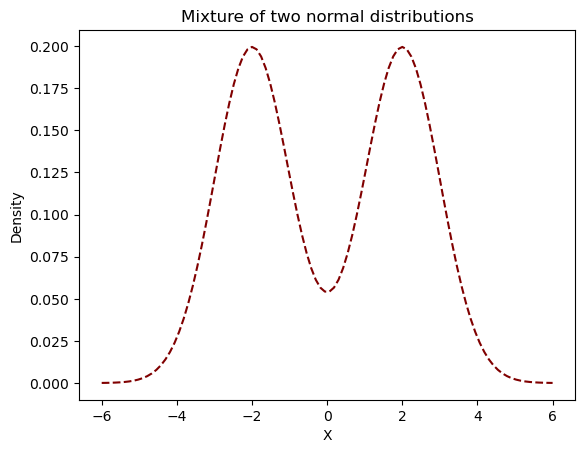

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
dist1 = norm(-2, 1)
dist2 = norm(2, 1)
X = lambda x: 0.5*dist1.pdf(x) + 0.5*dist2.pdf(x)
x_range = np.linspace(-6, 6, 100)
plt.plot(x_range, X(x_range),color='maroon', linestyle='--')
plt.xlabel('X')
plt.ylabel('Density')
plt.title('Mixture of two normal distributions')
plt.show()

This time instead of picking candidates uniformly at random we will select them using a normal distribution around the current state with a standard deviation of 1. 

Consider a transition from $x=3$ to $x=1/2$. What is the probability this transition will be accepted?


$$a_{1/2,3} = \min \left(1, \frac{\pi_{1/2} H_{3,1/2}}{\pi_3 H_{1/2,3}}\right) = \min \left(1, \frac{p(1/2 ; (1/2)N(-2,1) + (1/2)N(2,1)) * p(3 ; N(1/2,1))}{p(3 ; (1/2)N(-2,1) + (1/2)N(2,1)) * p(1/2 ; N(3,1))}\right)$$


However, the normal distribution is symmetric, meaning $p(1/2 ; N(3,1)) = p(3 ; N(1/2,1)$ so we can actually just cancel those terms.

So all we need to do is calculate the likelihoods of 1/2 and 3 in our target distribution:

$$ p(1/2 ; (1/2)N(-2,1) + (1/2)N(2,1)) = 0.07 $$

$$ p(3 ; (1/2)N(-2,1) + (1/2)N(2,1)) = 0.12 $$


$$a_{1/2,3} = \min \left(1, \frac{0.07}{0.12}\right) = 0.58$$


## MCMC Considerations

There are a number of considerations for using MCMC in practice.

First, while you are free to choose any proposal matrix $H$, some choices will work better than others.  Coosing a good proposal matrix is an art.  If your proposals are too close to your current point, then you accept almost every move, but it takes a long time to explore the whole space.  If your proposals are too far from your current point, you reject almost all moves, which also slows convergence.

Next, the chain may take some time from its starting point before it actually reaches the stationary distribution.  The length of initial transient data is referred to as the _burn-in_ time.  Generally you want to throw out an initial number of data steps, and then make sure the total run is much longer than what you threw out.

How long does it take the chain to reach steady-state?  If we could construct the entire transition matrix we could estimate this using the eigenvalues of the matrix.  However we almost never have that matrix, so one must determine whether the chain has converged through empirical measures.  One measure is simply to plot the statistic you are estimating as a function of time, and observe when it has settled down and doesn't change much.

There are more good considerations to take into account [here](https://personal.math.ubc.ca/~holmescerfon/teaching.html#asanotes) (Chapter 3).

## MCMC Example

```{margin}
This example is adapted from [MCMC Intuition for Everyone](https://towardsdatascience.com/mcmc-intuition-for-everyone-5ae79fff22b1) by Rahul Agarwal. 
```

Consider the Belgian Euro problem again this time with all that math in mind. Remeber, we observe a set of coin tosses and want to estimate the distribution of $p$, the probability of heads. 

Our data consists of $x$ heads and $n-x$ tails. 

If we assume a uniform prior, the target posterior is, as we know, 

$$ \text{Posterior}_x \propto \theta^x (1-\theta)^{n-x}. $$

An important point is that to use MCMC, we don't need to worry about the normalizing constant on the posterior. This is because the normalizing constant will appear in both the numerator and denominator in the expression

$$ a_{ij} = \min\left(1, \frac{\pi_i H_{ji}}{\pi_j H_{ij}}\right) $$

and so will cancel out.  This is very helpful!

Furthermore, we will generate candidates uniformly from the range $[0, 1]$ for simplicity.

Thus our acceptance criterion is simply:

$$ a_{ij} = \min\left(1, \frac{\theta_i^x(1-\theta_i)^{n-x}}{\theta_j^x(1-\theta_j)^{n-x}}\right). $$

Let's translate what we just did into code:

In [100]:
import random

# Our posterior; ignoring the normalizing constant
def posterior(theta, x, n):
    return (theta**x)*((1 - theta)**(n-x))

# Return true with probability p
def random_coin(p):
    unif = random.uniform(0,1)
    if unif < p:
        return True
    else:
        return False

# Run the Markov chain for coin flipping
def mcmc(n_steps, x, n):
    states = []
    cur = random.uniform(0, 1)
    for i in range(n_steps):
        states.append(cur)
        next = random.uniform(0, 1)
        # Calculate the acceptance probability
        ap = min(1, posterior(next, x, n) / posterior(cur, x, n)) 
        if random_coin(ap):
            cur = next
    return states 

Now let's run MCMC for 2000 steps:

In [134]:
random.seed(2)
samples = mcmc(2000, 100, 250)

and let's look at the properties of the samples.  Recall that the early steps of the Markov chain may not have reached steady state, so let's look at the mean over time:
    

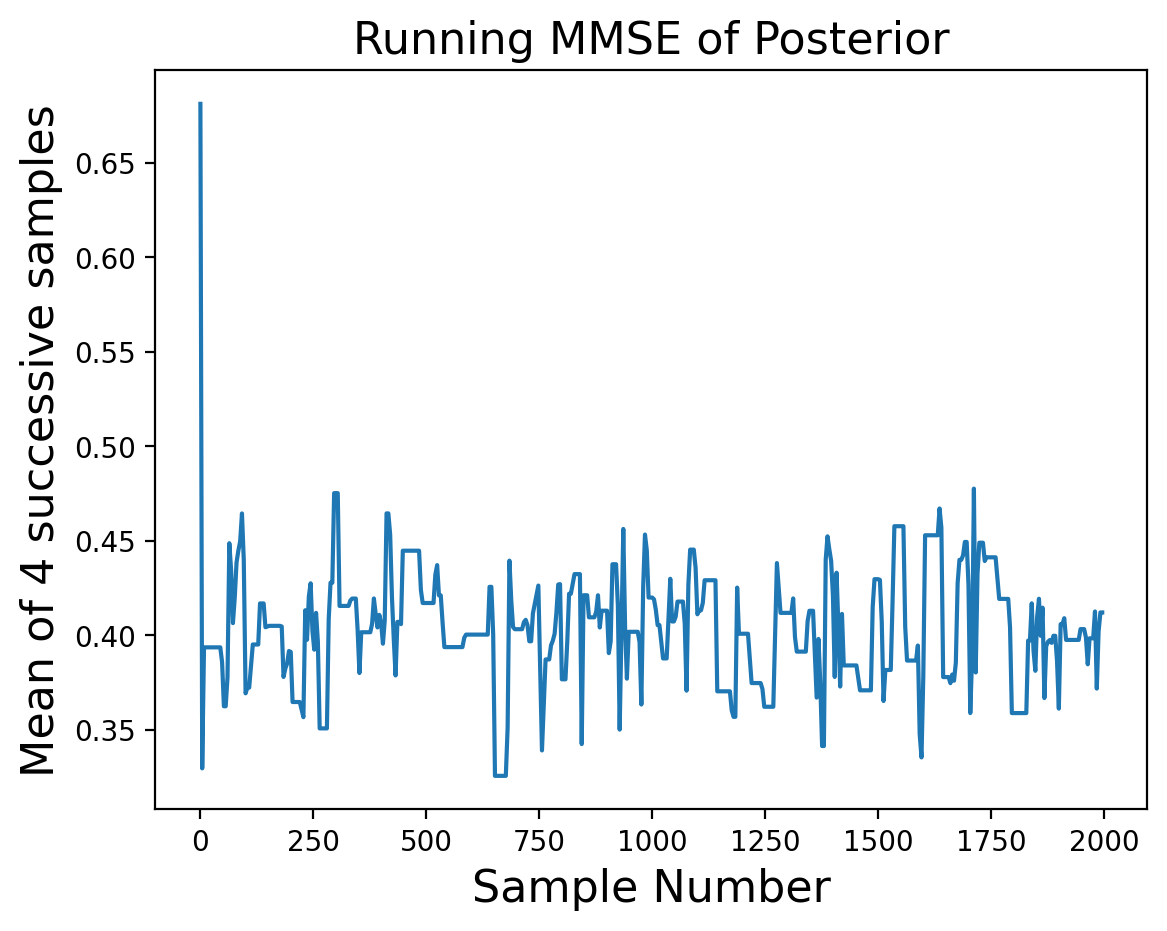

In [135]:
def group_means(x, N):
    '''return means of each N items (nonoverlapping windows)'''
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return ((cumsum[N:] - cumsum[:-N]) / float(N))[::N]

plt.plot(range(0, 2000, 4), group_means(samples, 4))
plt.xlabel('Sample Number', size = 16)
plt.ylabel('Mean of 4 successive samples', size = 16)
plt.title('Running MMSE of Posterior', size = 16);

It looks like the first dozen or so samples are not yet at steady-state, so let's eliminate them:

In [136]:
good_samples = samples[12:]

And let's look at the distribution of samples we've obtained from MCMC:

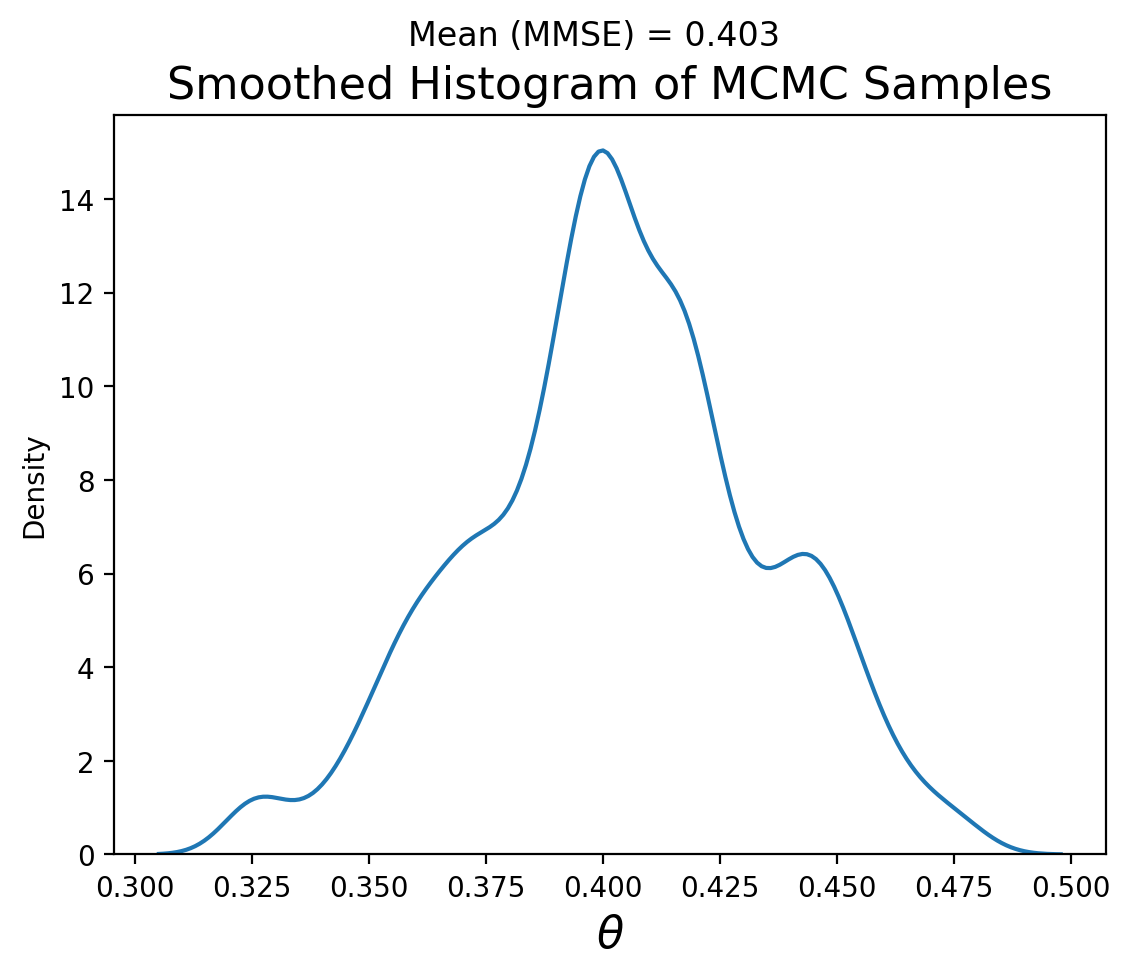

In [137]:
sns.kdeplot(good_samples)
plt.title('Smoothed Histogram of MCMC Samples', size = 16)
plt.suptitle(f'Mean (MMSE) = {np.mean(good_samples):0.3f}')
plt.xlabel(r'$\theta$', size = 16);

Note that the MMSE of $\theta$ is very close to 0.4, which is what we expect (100/250) and the distribution looks remniscent of our grid search result:

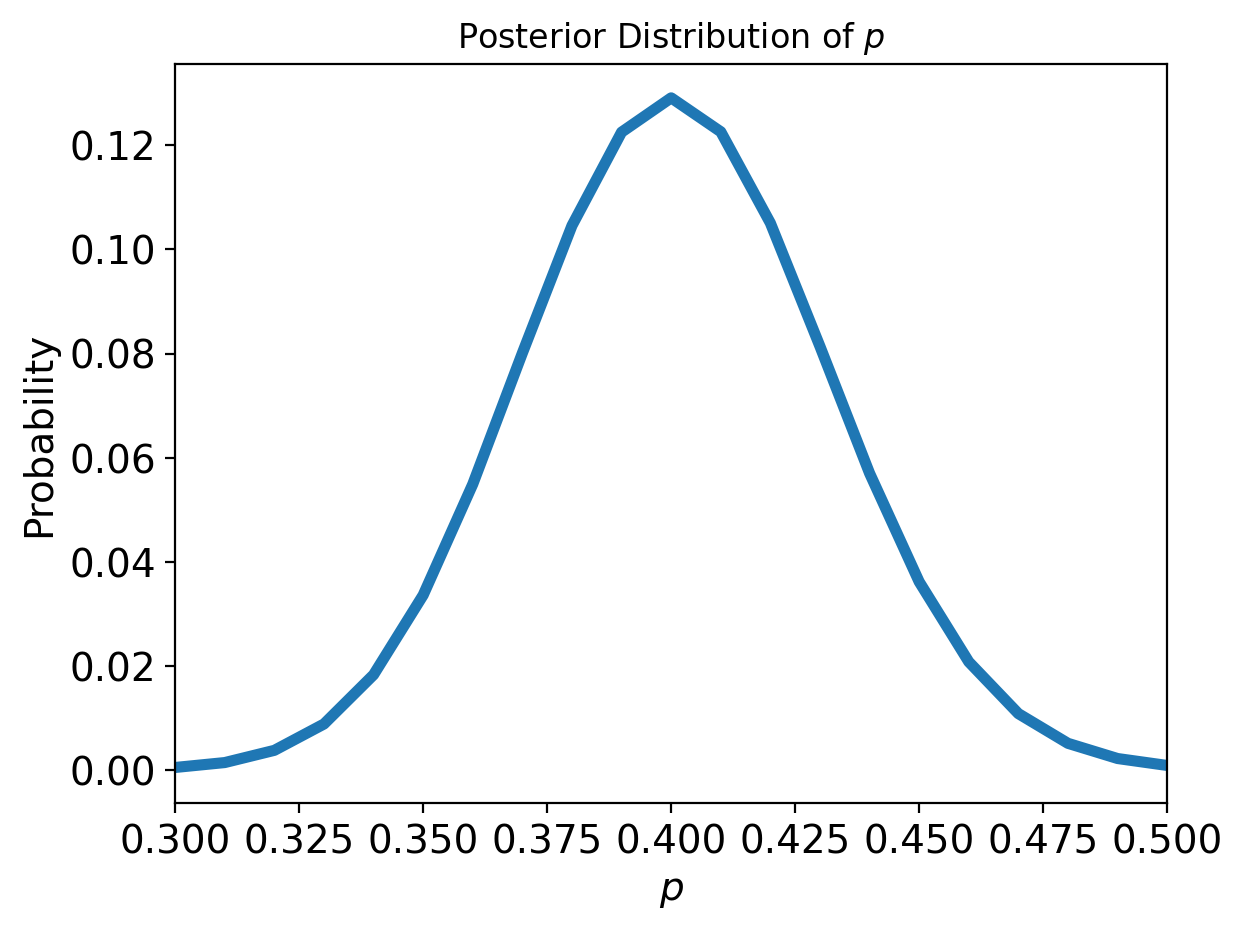

In [8]:
from scipy.stats import randint
from scipy.stats import binom

# our usual update function
def update(distribution, likelihood):
    distribution['probs'] = distribution['probs'] * likelihood
    prob_data = distribution['probs'].sum()
    distribution['probs'] = distribution['probs'] / prob_data
    return distribution

# start with uniform prior
p_dist = pd.DataFrame(index = np.arange(101)/100)
p_dist['probs'] = randint(0, 101).pmf(np.arange(101)) 

# compute whole-data likelihoods
likelihood = [binom.pmf(100, 250, p) for p in p_dist.index]

update(p_dist, likelihood);

p_dist.plot(lw = 4, legend = False, title = 'Posterior Distribution of $p$', fontsize = 14)
plt.xlabel('$p$', size = 14)
plt.ylabel('Probability', size = 14);
plt.xlim(.3,.5);